In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import random
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [7]:

# -------------------------------
# 1. FIXED DATA LOADING & PREPROCESSING
# -------------------------------

import os
import pandas as pd
import numpy as np
from collections import defaultdict

DATA_DIR = '/content/drive/MyDrive/data'  # CHANGE IF NEEDED

print("Loading CSV files with automatic column detection...")

all_clauses = []
labels = []

for file in os.listdir(DATA_DIR):
    if file.endswith('.csv'):
        path = os.path.join(DATA_DIR, file)
        df = pd.read_csv(path)

        # DEBUG: Show first few rows and columns
        print(f"\n--- {file} ---")
        print("Shape:", df.shape)
        print("Columns:", list(df.columns))
        print("First row:\n", df.head(1).to_string())


        if df.shape[1] >= 1:
            text_col = df.columns[0]  # First column is clause text
            clause_texts = df[text_col].astype(str).tolist()
            label = os.path.splitext(file)[0]  # e.g., 'acceleration'

            all_clauses.extend(clause_texts)
            labels.extend([label] * len(clause_texts))
        else:
            print(f"Skipping {file}: no data columns")

print(f"\nTotal clauses loaded: {len(all_clauses)}")
print(f"Unique labels: {len(set(labels))}")

Loading CSV files with automatic column detection...

--- agreement.csv ---
Shape: (500, 2)
Columns: ['clause_text', 'clause_type']
First row:
                                 clause_text clause_type
0  AGREEMENT. The parties agree as follows:   agreement

--- assignment.csv ---
Shape: (400, 2)
Columns: ['clause_text', 'clause_type']
First row:
                                                                                                                                clause_text clause_type
0  Assignment. This Agreement and all rights and obligations hereunder may not be assigned without the written consent of the other party.  assignment

--- bank-accounts.csv ---
Shape: (430, 2)
Columns: ['clause_text', 'clause_type']
First row:
                                                                                                                                                                                                                                                                

In [8]:
# Create pairs: same category = 1, different = 0
def create_pairs(clauses, labels, num_pairs_per_class=5000):
    label_to_clauses = defaultdict(list)
    for c, l in zip(clauses, labels):
        label_to_clauses[l].append(c)

    pairs = []
    pair_labels = []

    # Positive pairs (same label)
    pos_count = 0
    for l, cls in label_to_clauses.items():
        if len(cls) < 2: continue
        for i in range(len(cls)):
            for j in range(i+1, len(cls)):
                pairs.append((cls[i], cls[j]))
                pair_labels.append(1)
                pos_count += 1
                if pos_count >= num_pairs_per_class:
                    break
            if pos_count >= num_pairs_per_class:
                break
        if pos_count >= num_pairs_per_class:
            break

    # Negative pairs (different labels)
    label_list = list(label_to_clauses.keys())
    neg_count = 0
    while neg_count < num_pairs_per_class:
        l1, l2 = random.sample(label_list, 2)
        c1 = random.choice(label_to_clauses[l1])
        c2 = random.choice(label_to_clauses[l2])
        pairs.append((c1, c2))
        pair_labels.append(0)
        neg_count += 1

    return pairs, pair_labels

print("Creating balanced pairs...")
pairs, pair_labels = create_pairs(all_clauses, labels, num_pairs_per_class=3000)

print(f"Total pairs: {len(pairs)} | Positive: {sum(pair_labels)} | Negative: {len(pair_labels) - sum(pair_labels)}")

Creating balanced pairs...
Total pairs: 6000 | Positive: 3000 | Negative: 3000


In [9]:
# Split
X_train_pairs, X_temp_pairs, y_train, y_temp = train_test_split(pairs, pair_labels, test_size=0.3, stratify=pair_labels, random_state=SEED)
X_val_pairs, X_test_pairs, y_val, y_test = train_test_split(X_temp_pairs, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

In [10]:
# Tokenization
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
all_texts = [p[0] for p in pairs] + [p[1] for p in pairs]
tokenizer.fit_on_texts(all_texts)

def tokenize_pairs(pairs):
    left = [p[0] for p in pairs]
    right = [p[1] for p in pairs]
    left_seq = tokenizer.texts_to_sequences(left)
    right_seq = tokenizer.texts_to_sequences(right)
    left_pad = pad_sequences(left_seq, maxlen=MAX_LEN, padding='post')
    right_pad = pad_sequences(right_seq, maxlen=MAX_LEN, padding='post')
    return left_pad, right_pad

X_train_left, X_train_right = tokenize_pairs(X_train_pairs)
X_val_left, X_val_right = tokenize_pairs(X_val_pairs)
X_test_left, X_test_right = tokenize_pairs(X_test_pairs)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(f"Train: {X_train_left.shape}, Val: {X_val_left.shape}, Test: {X_test_left.shape}")

Train: (4200, 100), Val: (900, 100), Test: (900, 100)


In [20]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, query, key, value):
        # query: [B, T, D], key: [B, T, D], value: [B, T, D]
        scores = tf.matmul(query, key, transpose_b=True)  # [B, T, T]
        attention_weights = tf.nn.softmax(scores, axis=-1)
        context = tf.matmul(attention_weights, value)     # [B, T, D]
        return context

def build_bilstm_attention(embedding_dim=128, lstm_units=64):
    embedding = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim, input_length=MAX_LEN)

    left_input = Input(shape=(MAX_LEN,), name='left_input')
    right_input = Input(shape=(MAX_LEN,), name='right_input')

    left_embed = embedding(left_input)
    right_embed = embedding(right_input)

    bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True))
    left_lstm = bilstm(left_embed)
    right_lstm = bilstm(right_embed)

    # === CORRECT: Use custom Keras Layer for attention ===
    attention_layer = DotProductAttention()
    context = attention_layer(left_lstm, right_lstm, right_lstm)  # query=left, key=value=right

    # Use last timestep
    left_last = left_lstm[:, -1, :]
    right_last = right_lstm[:, -1, :]
    context_last = context[:, -1, :]

    merged = Concatenate()([left_last, right_last, context_last])
    dense = Dense(64, activation='relu')(merged)
    drop = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(drop)

    model = Model(inputs=[left_input, right_input], outputs=output)
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# -------------------------------
# 3. MODEL 2: Siamese CNN
# -------------------------------

def build_siamese_cnn(embedding_dim=128, filters=64):
    embedding = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim, input_length=MAX_LEN)

    def cnn_block(x):
        x = embedding(x)
        x = Conv1D(filters, 3, activation='relu')(x)
        x = Conv1D(filters, 4, activation='relu')(x)
        x = Conv1D(filters, 5, activation='relu')(x)
        x = GlobalMaxPooling1D()(x)
        return x

    left_input = Input(shape=(MAX_LEN,))
    right_input = Input(shape=(MAX_LEN,))

    left_encoded = cnn_block(left_input)
    right_encoded = cnn_block(right_input)

    merged = Concatenate()([left_encoded, right_encoded])
    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.5)(merged)
    output = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[left_input, right_input], outputs=output)
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# -------------------------------
# 4. TRAIN & EVALUATE
# -------------------------------

def train_and_evaluate(model_builder, name):
    print(f"\nTraining {name}...")
    model = model_builder()
    model.summary()

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5)
    ]

    start_time = time.time()
    history = model.fit(
        [X_train_left, X_train_right], y_train,
        validation_data=([X_val_left, X_val_right], y_val),
        epochs=50,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    train_time = time.time() - start_time

    # Predict
    y_pred_prob = model.predict([X_test_left, X_test_right]).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    print(f"{name} Results:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print(f"Training Time: {train_time:.2f}s")

    # Plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} - Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{name} - Accuracy')
    plt.legend()
    plt.show()

    return {
        'model': model,
        'name': name,
        'history': history,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob,
        'metrics': {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc},
        'time': train_time
    }


Training BiLSTM+Attention...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 128)  │  1,280,000 │ left_input[0][0], │
│ (Embedding)         │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 100, 128)  │     98,816 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ embedding_4[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product_attent… │ (None, 100, 128)  │          0 │ bidirectional_3[… │
│ (DotProductAttenti… │                   │            │ bidirectional_3[… │
│                     │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 128)       │          0 │ bidirectional_3[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 128)       │          0 │ bidirectional_3[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 128)       │          0 │ dot_product_atte… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 384)       │          0 │ get_item_6[0][0], │
│ (Concatenate)       │                   │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     24,640 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,403,521 (5.35 MB)

 Trainable params: 1,403,521 (5.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 418ms/step - accuracy: 0.6943 - loss: 0.5910 - val_accuracy: 0.7867 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step - accuracy: 0.8565 - loss: 0.3254 - val_accuracy: 0.9633 - val_loss: 0.1154 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - accuracy: 0.9794 - loss: 0.0654 - val_accuracy: 0.9833 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 356ms/step - accuracy: 0.9906 - loss: 0.0261 - val_accuracy: 0.9922 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 318ms/step - accuracy: 0.9985 - loss: 0.0070 - val_accuracy: 0.9900 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.9993 - loss: 0.0042 - val_accuracy: 0.9956 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 316ms/step - accuracy: 0.9973 - loss: 0.

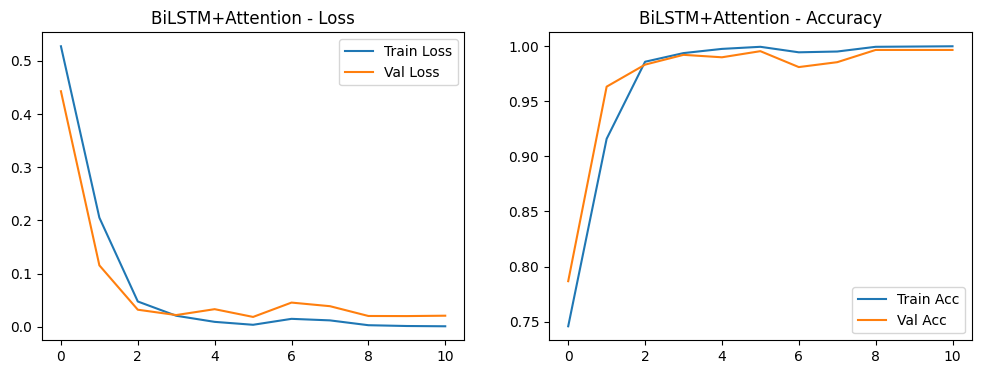


Training Siamese CNN...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 100, 128)  │  1,280,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 98, 64)    │     24,640 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 98, 64)    │     24,640 │ embedding_5[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 95, 64)    │     16,448 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 95, 64)    │     16,448 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 91, 64)    │     20,544 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 91, 64)    │     20,544 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_8[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        129 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,419,905 (5.42 MB)

 Trainable params: 1,419,905 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.8849 - loss: 0.4023 - val_accuracy: 0.9978 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 3.7697e-04 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 1.0000 - loss: 1.7499e-04 - val_accuracy: 1.0000 - val_loss: 6.5598e-05 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 1.0000 - loss: 4.6135e-05 - val_accuracy: 1.0000 - val_loss: 4.8362e-04 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 1.0000 - loss: 2.2580e-05 - val_accuracy: 1.0000 - val_loss: 1.6164e-04 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 1.0000 - loss: 2.2649e-05 - val_accuracy: 1.0000 - val_loss: 3.0977e-04 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step 

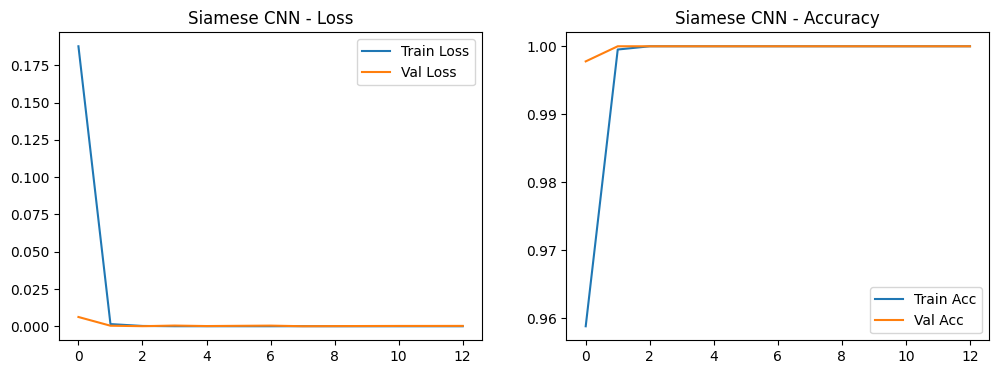

In [24]:
# Train both
results = {}
results['BiLSTM+Attention'] = train_and_evaluate(build_bilstm_attention, "BiLSTM+Attention")
results['Siamese CNN'] = train_and_evaluate(build_siamese_cnn, "Siamese CNN")

In [26]:

# 5. COMPARISON

print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)
for name, res in results.items():
    m = res['metrics']
    print(f"{name:20} | Acc: {m['acc']:.4f} | F1: {m['f1']:.4f} | AUC: {m['auc']:.4f} | Time: {res['time']:.1f}s")

# 6. QUALITATIVE EXAMPLES

def get_examples(model, name, X_left, X_right, pairs, y_true, y_pred, tokenizer, num=3):
    print(f"\n{name} - Qualitative Examples")
    correct = np.where((y_pred == 1) & (y_true == 1))[0]
    incorrect = np.where((y_pred == 1) & (y_true == 0))[0]

    def decode(seq):
        return ' '.join([tokenizer.index_word.get(i, '') for i in seq if i != 0])

    print("\nCorrectly Predicted Similar:")
    for idx in correct[:num]:
        l = decode(X_left[idx])
        r = decode(X_right[idx])
        print(f"Clause 1: {l}")
        print(f"Clause 2: {r}\n")

    print("Incorrectly Predicted Similar:")
    for idx in incorrect[:num]:
        l = decode(X_left[idx])
        r = decode(X_right[idx])
        print(f"Clause 1: {l}")
        print(f"Clause 2: {r}\n")

get_examples(results['BiLSTM+Attention']['model'], "BiLSTM+Attention", X_test_left, X_test_right, X_test_pairs, y_test, results['BiLSTM+Attention']['y_pred'], tokenizer)


FINAL COMPARISON
BiLSTM+Attention     | Acc: 0.9956 | F1: 0.9956 | AUC: 1.0000 | Time: 310.6s
Siamese CNN          | Acc: 1.0000 | F1: 1.0000 | AUC: 1.0000 | Time: 106.0s

BiLSTM+Attention - Qualitative Examples

Correctly Predicted Similar:
Clause 1: agreement the parties to this agreement intending to be legally bound agree as follows
Clause 2: agreement now therefore in consideration of the foregoing recitals and the mutual covenants and representations contained herein and other good and valuable consideration the receipt and sufficiency of which are hereby acknowledged the parties hereby agree as follows

Clause 1: agreement the parties agree as follows
Clause 2: agreement in consideration of the foregoing and of the covenants and agreements set forth in this agreement the company and the executive agree as follows

Clause 1: agreement this pooling and servicing agreement and all amendments hereof and supplements hereto
Clause 2: agreement now therefore for valuable consideration